In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
from keras_cv.models import StableDiffusion
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
import tensorflow.keras as keras

2.12.0
You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
diffusion_model = DiffusionModel(img_width = 512, img_height = 512, max_text_length=0)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [3]:
diffusion_model.layers

In [4]:
cnn_layers_in_order = []

for layer in range(len(diffusion_model.layers)):
    curr_layer = diffusion_model.layers[layer]
    if len(curr_layer.get_weights()) != 0:
        for sublayer in range(len(curr_layer.get_weights())):
            shape = curr_layer.get_weights()[sublayer].shape
            if len(shape) == 4 and shape[0] == 3 and shape[1] == 3:
                cnn_layers_in_order.append((layer, sublayer))

def get_cnn_layer(index):
    return diffusion_model.layers[cnn_layers_in_order[index][0]].get_weights()[cnn_layers_in_order[index][1]]

In [5]:
for i in range(len(cnn_layers_in_order)):
    print("Layer: {}, Shape: {}".format(i, get_cnn_layer(i).shape))

Layer: 0, Shape: (3, 3, 4, 320)
Layer: 1, Shape: (3, 3, 320, 320)
Layer: 2, Shape: (3, 3, 320, 320)
Layer: 3, Shape: (3, 3, 320, 320)
Layer: 4, Shape: (3, 3, 320, 320)
Layer: 5, Shape: (3, 3, 320, 320)
Layer: 6, Shape: (3, 3, 320, 640)
Layer: 7, Shape: (3, 3, 640, 640)
Layer: 8, Shape: (3, 3, 640, 640)
Layer: 9, Shape: (3, 3, 640, 640)
Layer: 10, Shape: (3, 3, 640, 640)
Layer: 11, Shape: (3, 3, 640, 1280)
Layer: 12, Shape: (3, 3, 1280, 1280)
Layer: 13, Shape: (3, 3, 1280, 1280)
Layer: 14, Shape: (3, 3, 1280, 1280)
Layer: 15, Shape: (3, 3, 1280, 1280)
Layer: 16, Shape: (3, 3, 1280, 1280)
Layer: 17, Shape: (3, 3, 1280, 1280)
Layer: 18, Shape: (3, 3, 1280, 1280)
Layer: 19, Shape: (3, 3, 1280, 1280)
Layer: 20, Shape: (3, 3, 1280, 1280)
Layer: 21, Shape: (3, 3, 1280, 1280)
Layer: 22, Shape: (3, 3, 1280, 1280)
Layer: 23, Shape: (3, 3, 1280, 1280)
Layer: 24, Shape: (3, 3, 2560, 1280)
Layer: 25, Shape: (3, 3, 1280, 1280)
Layer: 26, Shape: (3, 3, 2560, 1280)
Layer: 27, Shape: (3, 3, 1280, 1280)

In [10]:
def perform_branch_svd(layer_n, layer_n_plus_1):
 # Get the weights between layer n and n+1
    weights_n = get_cnn_layer(layer_n)
    weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)
  
    # how we adjust for concatenations in the u-net
    weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]

    # Perform SVD on the signed values of the weights between layers n and n+1
    signed_weights_n = weights_n.reshape(weights_n.shape[-1], -1)
    signed_weights_n_plus_1 = weights_n_plus_1.reshape(weights_n_plus_1.shape[-1], -1)
    abs_weights_n = np.abs(weights_n.reshape(weights_n.shape[-1], -1))
    abs_weights_n_plus_1 = np.abs(weights_n_plus_1.reshape(weights_n_plus_1.shape[-1], -1))
    u, s, vt = np.linalg.svd(abs_weights_n_plus_1, full_matrices=True)

    # Scatter plot of the filters from layer n on the first 2 left singular vectors
    layer_n_proj = u[:, :2].T @ abs_weights_n
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(layer_n_proj[0, :], layer_n_proj[1, :])
    plt.xlabel('Singular Vector 0')
    plt.ylabel('Singular Vector 1')

    # Scatter plot of the filters from layer n+1 on the first 2 right singular vectors
    layer_n_plus_1_proj = abs_weights_n_plus_1 @ vt.T[:, :2]
    plt.subplot(122)
    plt.scatter(layer_n_plus_1_proj[:, 0], layer_n_plus_1_proj[:, 1])
    plt.xlabel('Singular Vector 0')
    plt.ylabel('Singular Vector 1')

    plt.show()


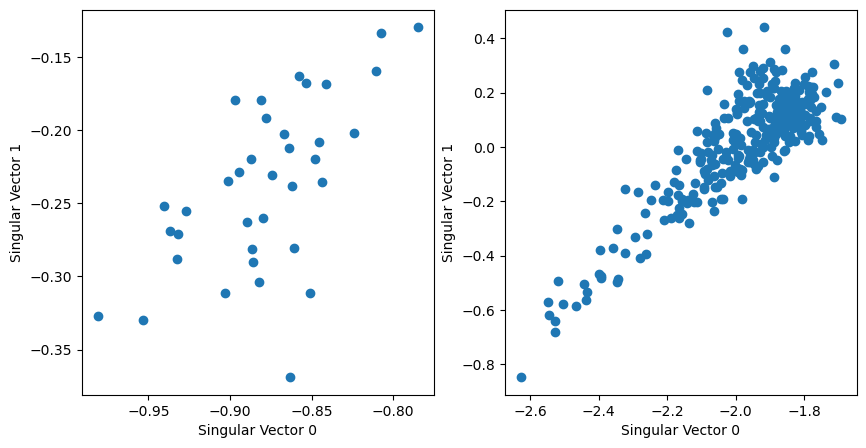

In [11]:
perform_branch_svd(0, 1)

In [21]:
def adaptive_branch_svd(layer_n, layer_n_plus_1):
    # This code will still work as before, but now we can also plot layers where the number of filters changes between layers n and n+1
    # but the interpretation of the second plot in that case is different (how channels connect in the second layer to the first layer)
 # Get the weights between layer n and n+1
    weights_n = get_cnn_layer(layer_n)
    weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)
  
    # how we adjust for concatenations in the u-net
    weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]

    # Perform SVD on the abs values of the weights between layers n and n+1
    abs_weights_n = np.abs(weights_n.reshape(weights_n.shape[-1], -1))
    abs_weights_n_plus_1 = np.abs(weights_n_plus_1.reshape(weights_n_plus_1.shape[-2], -1))
    u, s, vt = np.linalg.svd(abs_weights_n_plus_1, full_matrices=True)

    # Scatter plot of the filters from layer n on the first 2 left singular vectors
    layer_n_proj = u[:, :2].T @ abs_weights_n
    print(abs_weights_n.shape)
    print(layer_n_proj.shape)
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    #plt.scatter(layer_n_proj[0, :], layer_n_proj[1, :])
    plt.scatter(layer_n_proj[1, :], layer_n_proj[0, :])
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    # Scatter plot of the filters from layer n+1 on the first 2 right singular vectors
    layer_n_plus_1_proj = abs_weights_n_plus_1 @ vt.T[:, :2]
    plt.subplot(122)
    #plt.scatter(layer_n_plus_1_proj[:, 0], layer_n_plus_1_proj[:, 1])
    plt.scatter(layer_n_plus_1_proj[:, 1], layer_n_plus_1_proj[:, 0])
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    plt.show()




(320, 36)
(2, 36)


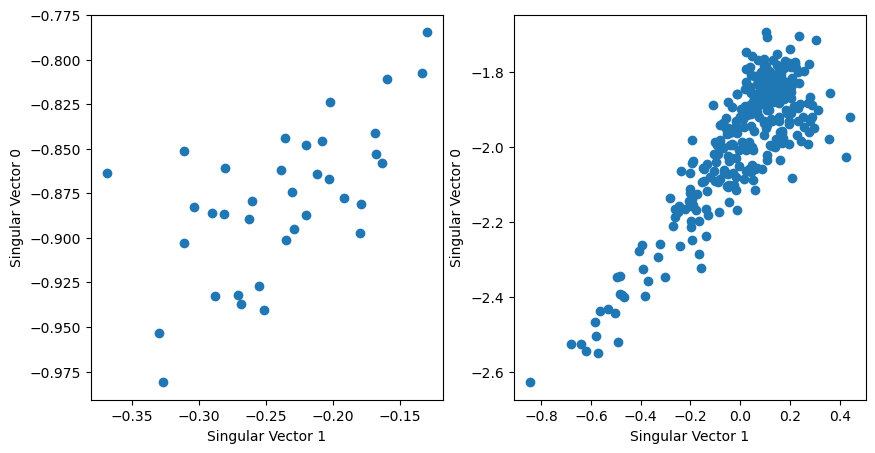

In [22]:
adaptive_branch_svd(0, 1)

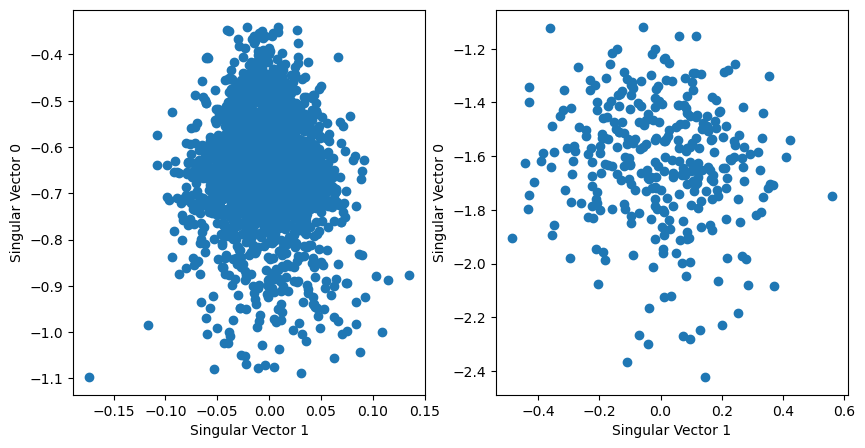

In [20]:
adaptive_branch_svd(1, 2)

In [48]:
def visualize_branch_svd_combined(layer_n, layer_n_plus_1):
    # This code will still work as before, but now we can also plot layers where the number of filters changes between layers n and n+1
    # but the interpretation of the second plot in that case is different (how channels connect in the second layer to the first layer)
 # Get the weights between layer n and n+1
    weights_n = get_cnn_layer(layer_n)
    weights_n_plus_1 = get_cnn_layer(layer_n_plus_1)
  
    # how we adjust for concatenations in the u-net
    weights_n_plus_1 = weights_n_plus_1[:, :, -weights_n.shape[-1]:, :]

    # Perform SVD on the abs values of the weights between layers n and n+1
    abs_weights_n = weights_n.reshape(weights_n.shape[-1], -1)
    abs_weights_n_plus_1 = weights_n_plus_1.reshape(weights_n_plus_1.shape[-2], -1)
    weights_between = abs_weights_n.T @ abs_weights_n_plus_1
    abs_weights_between = np.abs(weights_between)
    u, s, vt = np.linalg.svd(abs_weights_between, full_matrices=True)
    print(u.shape, s.shape, vt.shape)

    # Scatter plot of the filters from layer n on the first 2 left singular vectors
    layer_n_proj = u[:, :2].T @ abs_weights_n.T
    print(abs_weights_n.shape)
    print(layer_n_proj.shape)
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    #plt.scatter(layer_n_proj[0, :], layer_n_proj[1, :])
    plt.scatter(layer_n_proj[1, :], layer_n_proj[0, :])
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    # Scatter plot of the filters from layer n+1 on the first 2 right singular vectors
    layer_n_plus_1_proj = abs_weights_n_plus_1 @ vt.T[:, :2]
    plt.subplot(122)
    #plt.scatter(layer_n_plus_1_proj[:, 0], layer_n_plus_1_proj[:, 1])
    plt.scatter(layer_n_plus_1_proj[:, 1], layer_n_plus_1_proj[:, 0])
    plt.xlabel('Singular Vector 1')
    plt.ylabel('Singular Vector 0')

    plt.show()


(36, 36) (36,) (2880, 2880)
(320, 36)
(2, 320)


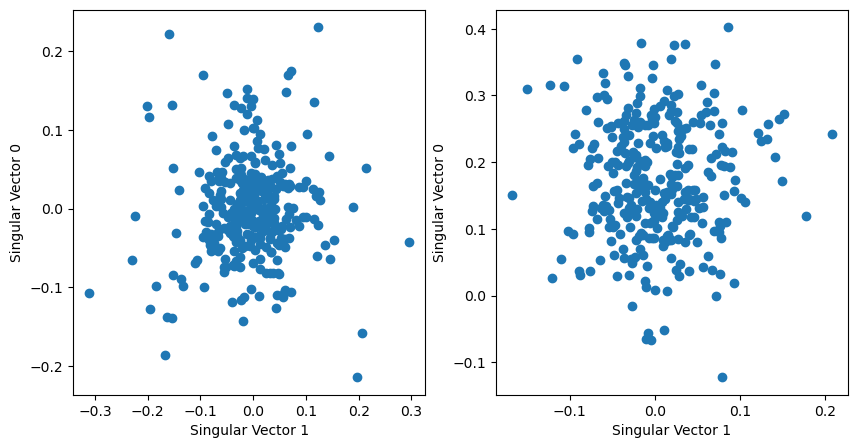

In [49]:
visualize_branch_svd_combined(0, 1)